In [ ]:
'''
Created on Nov 29, 2017
Program : Tweets extraction and preprocessing
References : https://docs.python.org/2/library/xml.etree.elementtree.html
@author: Neeraj Lad, Ritesh Tawde
'''

'''
DO NOT RUN THIS PORTION AS IT WILL TAKE A LOT OF TIME TO EXTRACT TWEETS
THIS IS JUST A TWEET SCRAPING FILE TO EXTRACT TWEETS USING SELENIUM
TWEETS ARE ALREADY BEEN EXTRACTED
'''

import xml.etree.ElementTree as ET
import selenium.webdriver as webdriver
from ttp import ttp
import json

class Tweet_Corpus:
    #user_id = None
    # tweet_id
    tweet_id = None
    # tweet_text
    tweet_text = None
    # 0 for female / 1 for male
    tweet_gender = None
    # encoding 18-24 = 0, 25-34 = 1, 35-49 = 2, 50-64 = 3, >64 = 4 
    tweet_age = None
    # get number of hashtags
    tweet_tags = None
    # is url mentioned 0 for False / 1 for True
    is_url_present = False
    
    def __init__(self, user, tw_id, tweet, gender, age, tags, is_url):
        # get user id
        self.user_id = user
        # get tweet id
        self.tweet_id = tw_id
        # get tweet text
        self.tweet_text = tweet
        # gender encoding
        self.tweet_gender = 0 if gender == 'FEMALE' else 1
        # age encoding
        if(age == '18-24'): self.tweet_age = 0
        elif(age == '25-34'): self.tweet_age = 1
        elif(age == '35-49'): self.tweet_age = 2
        elif(age == '50-64'): self.tweet_age = 3
        elif(age == '65-xx'): self.tweet_age = 4
        # of tags
        self.tweet_tags = tags
        # is url mentioned
        self.is_url_present = is_url

    def __repr__(self):
        return str(self.user_id) + '|' + str(self.tweet_id) + '|' + str(self.tweet_text) + '|' + str(self.tweet_gender) + '|' + str(self.tweet_age) + '|' + str(self.tweet_tags) + '|' + str(self.is_url_present)

    
class Scrape_tweets:
    
    def __init__(self):
        self.ttp_parser = ttp.Parser()
    
    def config_selenium(self):
        options = webdriver.ChromeOptions()
        options.add_argument('headless')
        driver = webdriver.Chrome(chrome_options=options, executable_path='../../chrome_driver/chromedriver.exe')
        return driver
    
    def process_tweet_data(self, tweet_text):
        parse_result = self.ttp_parser.parse(tweet_text)
        return len(parse_result.tags), True if len(parse_result.urls) > 0 else False 
    
    def read_truth_file(self):
        truth_file = open('../dataset/english_corp/truth.txt', 'r')
        # get selenium driver
        sel_driver = self.config_selenium()
        all_tweets_corpus = []
        user_cnt = 1
        for line in truth_file:
            file_id, gender, age = line.strip().split(":::")
            print('User: %d | Start: %s' % (user_cnt, file_id))
            # read each user file and all tweets from each of the file
            filename = '../dataset/english_corp/' + file_id + '.xml'
            user_file = open(filename, 'r')
            tree = ET.parse(user_file)
            root = tree.getroot()
            tweet_cnt = 0
            for all_docs in root.findall('documents'):
                for sub_doc in all_docs:
                    tweet_cnt += 1
                    if tweet_cnt > 50:
                        break
                    tweet_id = sub_doc.get('id')
                    tweet_url = sub_doc.get('url')
                    #print(tweet_id + ":" + file_id)
                    sel_driver.get(tweet_url)
                    element = sel_driver.find_elements_by_css_selector('div.tweet')
                    if(len(element) == 0): continue
                    tweet_text = element[0].find_element_by_css_selector('p.tweet-text').text
                    tags, is_url = self.process_tweet_data(tweet_text)
                    tc = Tweet_Corpus(file_id, tweet_id, tweet_text, gender, age, tags, is_url)
                    all_tweets_corpus.append(tc)
                    with open('../tweet_dumps_json/complete_tweets.json', 'a') as f:
                        f.write(json.dumps(tc.__dict__) + '\n')

                if tweet_cnt > 50:
                    break
            user_cnt += 1
            
if __name__ == '__main__':
    # get ground truth
    scr = Scrape_tweets()
    scr.read_truth_file()

In [2]:
'''
Created on Nov 29, 2017
Program : Tweets extraction and preprocessing
References : https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression
@author: Neeraj Lad, Ritesh Tawde
'''

'''
THIS PORTION IS TO BE RUN FIRST FOR DATA PREPROCESSING PURPOSES
IT WILL THEN GENERATE TRAINING AND TESTING CSV FILES TO BE USED FOR CLASSIFICATION
'''

import csv
import json
import re
from time import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from stemming.porter2 import stem

import numpy as np
import pandas as pd

class TwPreprocess(object):
    tweets = None
    stop_words = None
    
    def __init__(self, file_name):
        with open(file_name, 'r') as json_file:
            self.tweets = json_file.read().strip().split('\n')
        self.tweets = [json.loads(tweet) for tweet in self.tweets]
        self.stop_words = set(stopwords.words('english'))
        
    def process_tweets(self, tweet_data):
        for line in tweet_data:
            # remove mentions, hashtags, urls (as much as possible)
            tweet = line['tweet_text']
            tweet = (' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", line['tweet_text']).split())).lower()
            line['tweet_text'] = self.remove_stopwords(tweet)
        return tweet_data
    
    def remove_blank_tweets(self, tweet_data):
        for index, line in enumerate(tweet_data):
            if(line['tweet_text'] == ''):
                tweet_data.pop(index)
        return tweet_data
    
    def remove_stopwords(self, tweet_line):
        word_tokens = word_tokenize(tweet_line)
        filtered_line = []
        
        for w in word_tokens:
            if w not in self.stop_words:
                w = stem(w)
                filtered_line.append(w)
        
        return ' '.join(filtered_line)

    def write_to_csv(self, tweet_data, tweet_type):
        tweet_file = open(tweet_type + '.csv', 'w')
        writer = csv.writer(tweet_file)
        
        count = 0
        for line in tweet_data:
            if count == 0:
                title_row = line.keys()
                writer.writerow(title_row)
                count += 1
            writer.writerow(line.values())
        tweet_file.close()

if __name__ == '__main__':
    
    # object for one hot encoder
    enc = OneHotEncoder()
    
    # loading data
    twp = TwPreprocess('../tweet_dumps_json/complete_tweets.json')
    
    print("Data preprocessing in progress...")
    
    training_data, testing_data = train_test_split(twp.tweets, test_size=0.1, random_state=30)
    
    # preprocess training data
    training_data = twp.process_tweets(training_data)
    training_data = twp.remove_blank_tweets(training_data)
    
    # preprocess testing data
    testing_data = twp.process_tweets(testing_data)
    testing_data = twp.remove_blank_tweets(testing_data)
    
    # conversion to csv
    twp.write_to_csv(training_data, "training")
    twp.write_to_csv(testing_data, "testing")
    
    print("Data preprocessing is done!!!")

Data preprocessing in progress...
Data preprocessing is done!!!







[INFO]: Gender classification...
Baseline
Total time taken : (training and testing)  0.014178991317749023
[INFO]
Classifier :  Baseline
Accuracy :  0.501196399407
Classification report :               precision    recall  f1-score   support

          0       0.44      0.50      0.47     11523
          1       0.56      0.50      0.53     14806

avg / total       0.51      0.50      0.50     26329

Confusion matrix :  [[5736 5787]
 [7346 7460]]
Multinomial Naive Bayes
Total time taken : (training and testing)  0.2015211582183838
[INFO]
Classifier :  Multinomial Naive Bayes
Accuracy :  0.799080861408
Classification report :               precision    recall  f1-score   support

          0       0.82      0.69      0.75     11523
          1       0.79      0.88      0.83     14806

avg / total       0.80      0.80      0.80     26329

Confusion matrix :  [[ 7980  3543]
 [ 1747 13059]]
Linear SVC
Total time taken : (training and testing)  45.35634136199951
[INFO]
Classifier :  Lin

C:\Users\Acer Valued Customer\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Total time taken : (training and testing)  4.286914587020874
[INFO]
Classifier :  SGD Classifier-l2
Accuracy :  0.798435185537
Classification report :               precision    recall  f1-score   support

          0       0.78      0.75      0.77     11523
          1       0.81      0.83      0.82     14806

avg / total       0.80      0.80      0.80     26329

Confusion matrix :  [[ 8678  2845]
 [ 2462 12344]]
SGD Classifier-elasticnet


C:\Users\Acer Valued Customer\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Total time taken : (training and testing)  7.972743272781372
[INFO]
Classifier :  SGD Classifier-elasticnet
Accuracy :  0.801435679289
Classification report :               precision    recall  f1-score   support

          0       0.79      0.74      0.77     11523
          1       0.81      0.85      0.83     14806

avg / total       0.80      0.80      0.80     26329

Confusion matrix :  [[ 8545  2978]
 [ 2250 12556]]
Gradient Boosting Classifier
Total time taken : (training and testing)  62.83875870704651
[INFO]
Classifier :  Gradient Boosting Classifier
Accuracy :  0.658551407194
Classification report :               precision    recall  f1-score   support

          0       0.70      0.38      0.50     11523
          1       0.65      0.87      0.74     14806

avg / total       0.67      0.66      0.63     26329

Confusion matrix :  [[ 4420  7103]
 [ 1887 12919]]


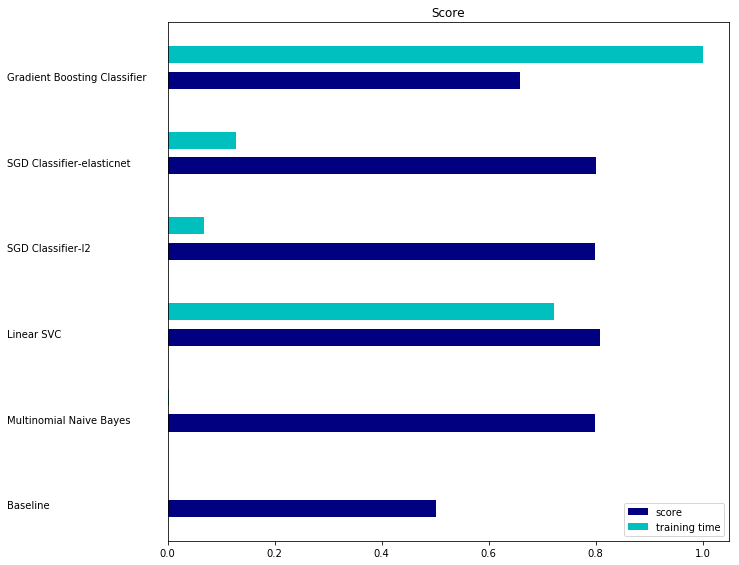











[INFO]: Age classification (imbalanced)...
Baseline
Total time taken : (training and testing)  0.023111820220947266
[INFO]
Classifier :  Baseline
Accuracy :  0.205021079418
Classification report :               precision    recall  f1-score   support

          0       0.08      0.21      0.11      1859
          1       0.35      0.20      0.26      9214
          2       0.41      0.20      0.27     10494
          3       0.18      0.21      0.19      4514
          4       0.01      0.22      0.02       248

avg / total       0.32      0.21      0.24     26329

Confusion matrix :  [[ 393  377  339  336  414]
 [1794 1867 1812 1885 1856]
 [2046 2123 2145 2098 2082]
 [ 853  902  937  939  883]
 [  58   48   48   40   54]]
Multinomial Naive Bayes
Total time taken : (training and testing)  0.3291032314300537
[INFO]
Classifier :  Multinomial Naive Bayes
Accuracy :  0.691366933799
Classification report :               precision    recall  f1-score   support

          0       0.

C:\Users\Acer Valued Customer\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Total time taken : (training and testing)  19.357457876205444
[INFO]
Classifier :  SGD Classifier-l2
Accuracy :  0.696190512363
Classification report :               precision    recall  f1-score   support

          0       0.60      0.49      0.54      1859
          1       0.69      0.72      0.70      9214
          2       0.72      0.73      0.73     10494
          3       0.68      0.64      0.66      4514
          4       0.62      0.81      0.70       248

avg / total       0.69      0.70      0.69     26329

Confusion matrix :  [[ 916  473  350  109   11]
 [ 270 6619 1741  545   39]
 [ 244 1797 7706  698   49]
 [  87  665  850 2888   24]
 [   1   11   23   12  201]]
SGD Classifier-elasticnet


C:\Users\Acer Valued Customer\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Total time taken : (training and testing)  36.447789907455444
[INFO]
Classifier :  SGD Classifier-elasticnet
Accuracy :  0.697215997569
Classification report :               precision    recall  f1-score   support

          0       0.62      0.47      0.53      1859
          1       0.69      0.72      0.70      9214
          2       0.71      0.75      0.73     10494
          3       0.70      0.63      0.66      4514
          4       0.72      0.76      0.74       248

avg / total       0.70      0.70      0.70     26329

Confusion matrix :  [[ 870  495  372  113    9]
 [ 251 6620 1836  493   14]
 [ 221 1780 7856  607   30]
 [  70  657  946 2822   19]
 [   1   18   32    8  189]]
Gradient Boosting Classifier
Total time taken : (training and testing)  349.92648577690125
[INFO]
Classifier :  Gradient Boosting Classifier
Accuracy :  0.531087394128
Classification report :               precision    recall  f1-score   support

          0       0.83      0.13      0.22      1859
    

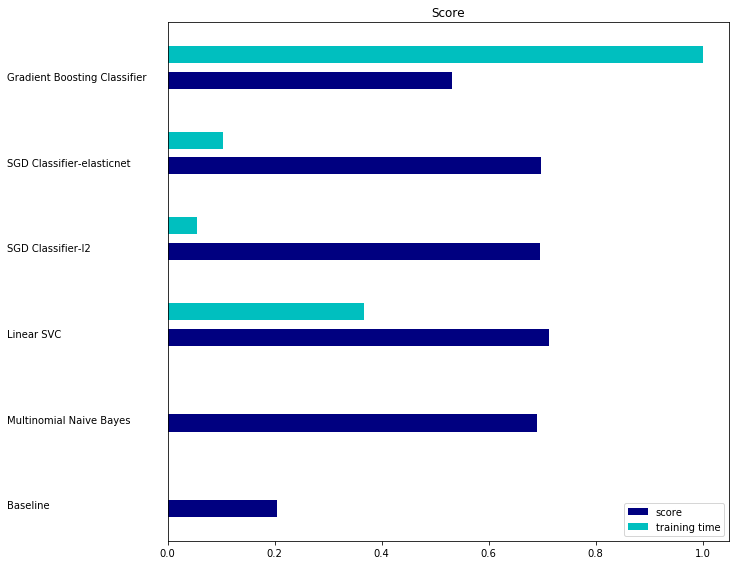











[INFO]: Age classification (balanced)...
Baseline
Total time taken : (training and testing)  0.034223079681396484
[INFO]
Classifier :  Baseline
Accuracy :  0.205021079418
Classification report :               precision    recall  f1-score   support

          0       0.08      0.21      0.11      1859
          1       0.35      0.20      0.26      9214
          2       0.41      0.20      0.27     10494
          3       0.18      0.21      0.19      4514
          4       0.01      0.22      0.02       248

avg / total       0.32      0.21      0.24     26329

Confusion matrix :  [[ 393  377  339  336  414]
 [1794 1867 1812 1885 1856]
 [2046 2123 2145 2098 2082]
 [ 853  902  937  939  883]
 [  58   48   48   40   54]]
Multinomial Naive Bayes
Total time taken : (training and testing)  0.23962688446044922
[INFO]
Classifier :  Multinomial Naive Bayes
Accuracy :  0.649018192867
Classification report :               precision    recall  f1-score   support

          0       0.3

C:\Users\Acer Valued Customer\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Total time taken : (training and testing)  38.58108448982239
[INFO]
Classifier :  SGD Classifier-l2
Accuracy :  0.669451935129
Classification report :               precision    recall  f1-score   support

          0       0.41      0.62      0.49      1859
          1       0.71      0.66      0.69      9214
          2       0.76      0.67      0.71     10494
          3       0.59      0.70      0.64      4514
          4       0.53      0.81      0.64       248

avg / total       0.69      0.67      0.67     26329

Confusion matrix :  [[1157  323  234  132   13]
 [ 821 6126 1355  858   54]
 [ 640 1642 6984 1152   76]
 [ 224  536  563 3158   33]
 [   6   15   17    9  201]]
SGD Classifier-elasticnet


C:\Users\Acer Valued Customer\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Total time taken : (training and testing)  71.77421402931213
[INFO]
Classifier :  SGD Classifier-elasticnet
Accuracy :  0.664970184967
Classification report :               precision    recall  f1-score   support

          0       0.38      0.65      0.48      1859
          1       0.72      0.65      0.68      9214
          2       0.77      0.65      0.71     10494
          3       0.59      0.72      0.65      4514
          4       0.57      0.83      0.68       248

avg / total       0.69      0.66      0.67     26329

Confusion matrix :  [[1205  310  202  135    7]
 [ 959 6005 1286  916   48]
 [ 751 1590 6850 1229   74]
 [ 223  456  565 3241   29]
 [   5   12   15    9  207]]
Gradient Boosting Classifier
Total time taken : (training and testing)  751.2024612426758
[INFO]
Classifier :  Gradient Boosting Classifier
Accuracy :  0.424057123324
Classification report :               precision    recall  f1-score   support

          0       0.18      0.54      0.27      1859
      

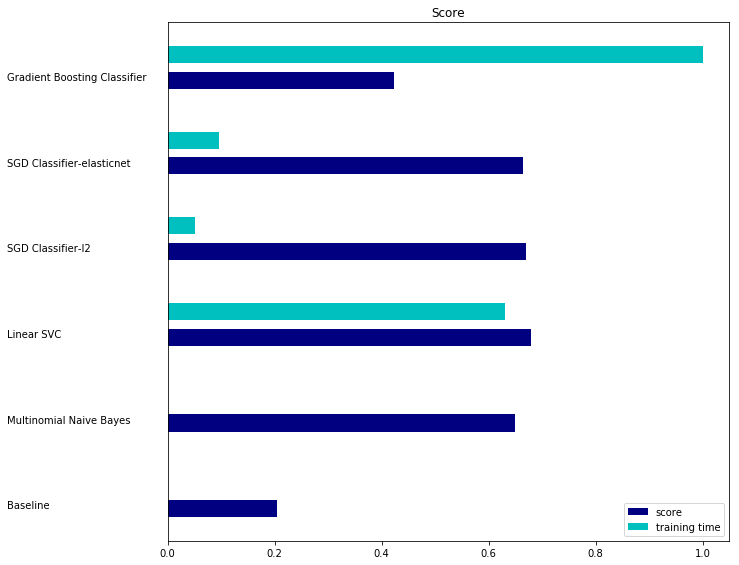

In [3]:
'''
Created on Nov 29, 2017
Program : Tweets extraction and preprocessing
References : http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#sphx-glr-auto-examples-text-document-classification-20newsgroups-pyx
@author: Neeraj Lad, Ritesh Tawde
'''
'''
THIS PORTION OF CODE IS TO BE EXECUTED POST PREPROCESSING
THIS PORTION PERFORMS THE TASK OF CLASSIFICATION, GIVING OUT RESULTS AND PLOTTING GRAPHS
'''

import csv
import json
import re
from time import time

from imblearn.over_sampling.random_over_sampler import RandomOverSampler
from scipy.sparse import coo_matrix, hstack
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm.classes import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def testing_classifiers(classifier, classifier_name, training_data, training_labels, testing_data, testing_labels):
    start_time = time()
    classifier.fit(training_data, training_labels)
    predicted = classifier.predict(testing_data)
    end_time = time()
    print("Total time taken : (training and testing) ", (end_time - start_time))
    # testing accuracy
    accuracy_score = metrics.accuracy_score(testing_labels, predicted)
    print("[INFO]")
    print("Classifier : ", classifier_name)
    print("Accuracy : ", accuracy_score)
    print("Classification report : ", metrics.classification_report(testing_labels, predicted))
    # confusion matrix
    conf_matrix = metrics.confusion_matrix(testing_labels, predicted)
    print("Confusion matrix : ", conf_matrix)
    
    return classifier_name, accuracy_score, (end_time - start_time)

def results_classification(training_data, training_labels, testing_data, testing_labels):
    # testing starts here
    classifiers_vector = [(DummyClassifier(strategy="uniform", random_state=10), "Baseline"),
        (MultinomialNB(alpha=1e-2), "Multinomial Naive Bayes"),
        (LinearSVC(penalty='l2', dual=False, tol=1e-4), "Linear SVC"),
        (SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=50), "SGD Classifier-l2"),
        (SGDClassifier(loss='hinge', penalty='elasticnet', alpha=1e-3, n_iter=50), "SGD Classifier-elasticnet"),
        (GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), "Gradient Boosting Classifier")]
    
    # all results
    results = []
    
    for classifier, classifier_name in classifiers_vector:
        print(classifier_name)
        # scaling data for SGD
        if "SGD" in classifier_name:
            scalar = StandardScaler(with_mean=False)
            scalar.fit(training_data)
            training_data = scalar.transform(training_data)
            testing_data = scalar.transform(testing_data)
        results.append(testing_classifiers(classifier, classifier_name, training_data, training_labels, testing_data, testing_labels))
    
    indices = np.arange(len(results))    
    results = [[result[idx] for result in results]for idx in range(3)]
    
    classifier_name, acc_score, total_time = results
    total_time = np.array(total_time) / np.max(total_time)
    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, acc_score, .2, label="score", color='navy')
    plt.barh(indices + .3, total_time, .2, label="training time",
             color='c')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    
    for i, c in zip(indices, classifier_name):
        plt.text(-.3, i, c)
    
    plt.show()

if __name__ == '__main__':
    # object for one hot encoder
    enc = OneHotEncoder()
    training_data = pd.read_csv("training.csv")
    testing_data = pd.read_csv("testing.csv")
    
    # url present/absent mapping
    training_data['is_url_present'] = np.where(training_data['is_url_present'] == True, 1, 0)
    # profiling gender of an author
    
    # count vectorizer for training and testing data
    training_tweets = training_data['tweet_text']
    testing_tweets = testing_data['tweet_text']
    vectorizer = TfidfVectorizer()
    training_doc_term = coo_matrix(vectorizer.fit_transform(training_tweets.values.astype('U')))
    testing_doc_term = coo_matrix(vectorizer.transform(testing_tweets.values.astype('U')))
    
    ###################################################################################################################
    # classifying gender
    training_labels = training_data['tweet_gender']
    testing_labels = testing_data['tweet_gender']
    
    training_rest = np.vstack((np.array(training_data['tweet_age']), np.array(training_data['tweet_tags']), np.array(training_data['is_url_present'])))
    training_rest = training_rest.T
    training_rest = coo_matrix(enc.fit_transform(training_rest))

    entire_training_frame = hstack([training_doc_term, training_rest])
    # entire_training_frame = np.concatenate((training_doc_term.todense(), training_rest.todense()), axis = 1)

    print("\n\n\n\n")
    print('[INFO]: Gender classification...')
    testing_rest = np.vstack((np.array(testing_data['tweet_age']), np.array(testing_data['tweet_tags']), np.array(testing_data['is_url_present'])))
    testing_rest = testing_rest.T
    testing_rest = coo_matrix(enc.transform(testing_rest))

    entire_testing_frame = hstack([testing_doc_term, testing_rest])
    # entire_testing_frame = np.concatenate((testing_doc_term.todense(), testing_rest.todense()), axis = 1)

    # based on gender as response variable
    results_classification(entire_training_frame, training_labels, entire_testing_frame, testing_labels)
    
    print("\n\n\n\n")
    
    ###################################################################################################################
    # classifying age class imbalanced
    
    training_labels = training_data['tweet_age']
    testing_labels = testing_data['tweet_age']
    
    training_rest = np.vstack((np.array(training_data['tweet_gender']), np.array(training_data['tweet_tags']), np.array(training_data['is_url_present'])))
    training_rest = training_rest.T
    training_rest = coo_matrix(enc.fit_transform(training_rest))
    entire_training_frame = hstack([training_doc_term, training_rest])

    print("\n\n\n\n")
    print('[INFO]: Age classification (imbalanced)...')
    testing_rest = np.vstack((np.array(testing_data['tweet_gender']), np.array(testing_data['tweet_tags']), np.array(testing_data['is_url_present'])))
    testing_rest = testing_rest.T
    testing_rest = coo_matrix(enc.transform(testing_rest))
    entire_testing_frame = hstack([testing_doc_term, testing_rest])
    
    # based on age as response variable
    results_classification(entire_training_frame, training_labels, entire_testing_frame, testing_labels)
    print("\n\n\n\n")
    
    ###################################################################################################################
    # classifying age class balanced
    
    training_labels = training_data['tweet_age']
    testing_labels = testing_data['tweet_age']
    
    training_rest = np.vstack((np.array(training_data['tweet_gender']), np.array(training_data['tweet_tags']), np.array(training_data['is_url_present'])))
    training_rest = training_rest.T
    training_rest = coo_matrix(enc.fit_transform(training_rest))
    entire_training_frame = hstack([training_doc_term, training_rest])
    
    # random over sampling 
    ros = RandomOverSampler(random_state=40)
    sm_training_frame, sm_training_labels = ros.fit_sample(entire_training_frame, training_labels)
    
    print("\n\n\n\n")
    print('[INFO]: Age classification (balanced)...')
    testing_rest = np.vstack((np.array(testing_data['tweet_gender']), np.array(testing_data['tweet_tags']), np.array(testing_data['is_url_present'])))
    testing_rest = testing_rest.T
    testing_rest = coo_matrix(enc.transform(testing_rest))
    entire_testing_frame = hstack([testing_doc_term, testing_rest])
    
    # based on age as response variable
    results_classification(sm_training_frame, sm_training_labels, entire_testing_frame, testing_labels)
    print("\n\n\n\n")